# ASSIGNMENT 2

Balzani Lorenzo, Deana Alessia and Guizzetti Thomas

{ lorenzo.balzani, alessia.deana, thomas.guizzetti }@studio.unibo.it

In [ ]:
"""!pip install transformers
!pip install -U torchmetrics
!pip install datasets
!pip install accelerate -U
!pip install pdflatex
!pip install tikzplotlib"""


'!pip install transformers\n!pip install -U torchmetrics\n!pip install datasets\n!pip install accelerate -U\n!pip install pdflatex\n!pip install tikzplotlib'

In [ ]:
# Libraries imports

# File management
import os, shutil
import sys

# Dataframe management
import pandas as pd

# Data manipulation
import numpy as np
import math
import random

# Download files
import urllib.request
import tarfile

# NN managers
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchmetrics

# Plotting
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


# stats
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

## TASK 1 - CORPUS

downlad and create dataframe for arguments datasets.

In [ ]:
# path for dataset files
file_path_train = os.path.join(os.getcwd(), "Datasets", "arguments-training.tsv")
file_path_test = os.path.join(os.getcwd(), "Datasets", "arguments-test.tsv")
file_path_validation = os.path.join(os.getcwd(), "Datasets", "arguments-validation.tsv")

In [ ]:
train_args = pd.read_csv(file_path_train, sep='\t')
test_args = pd.read_csv(file_path_test, sep='\t')
validation_args = pd.read_csv(file_path_validation, sep='\t')

In [ ]:
train_args = pd.DataFrame(train_args)
test_args = pd.DataFrame(test_args)
validation_args = pd.DataFrame(validation_args)

In [ ]:
#example of datafram
train_args

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...
...,...,...,...,...
5388,E08016,The EU should integrate the armed forces of it...,in favor of,"On the one hand, we have Russia killing countl..."
5389,E08017,Food whose production has been subsidized with...,in favor of,The subsidies were originally intended to ensu...
5390,E08018,Food whose production has been subsidized with...,in favor of,These products come mainly from large enterpri...
5391,E08019,Food whose production has been subsidized with...,in favor of,Subsidies often make farmers in recipient coun...


### Annotations

In this assignment, you are tasked to address a multi-label classification problem.

You are going to consider **level 3** categories:

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

**How to do that?**

You have to merge (**logical OR**) annotations of level 2 categories belonging to the same level 3 category.

**Pay attention to shared level 2 categories** (e.g., Hedonism). $\rightarrow$ [see Table 1 in the original paper.](https://aclanthology.org/2022.acl-long.306/)

#### Example

```
Self-direction: thought:    0
Self-direction: action:     1
Stimulation:                0
Hedonism:                   1

Openess to change           1
```

In [ ]:
# download and creations of dataframe for labels datasets

# Step 1
file_path_labels_train = os.path.join(os.getcwd(), "Datasets", "labels-training.tsv")
file_path_labels_test = os.path.join(os.getcwd(), "Datasets", "labels-test.tsv")
file_path_labels_validation = os.path.join(os.getcwd(), "Datasets", "labels-validation.tsv")

#Step 2
train_labels = pd.read_csv(file_path_labels_train, sep='\t')
test_labels = pd.read_csv(file_path_labels_test, sep='\t')
validation_labels = pd.read_csv(file_path_labels_validation, sep='\t')

# Step 3: Merge arguments and labels DataFrames for each split
train_data = pd.merge(train_args, train_labels, on='Argument ID', how='inner')
val_data = pd.merge(validation_args, validation_labels, on='Argument ID', how='inner')
test_data = pd.merge(test_args, test_labels, on='Argument ID', how='inner')

In [ ]:
# label array for leve 2 and 3
level3_category = ['Openness to change', 'Self-enhancement', 'Conversation', 'Self-transcendence']
level2_category = ['Self-direction: thought', 'Self-direction: action', 'Stimulation','Achievement', 'Hedonism',  'Power: dominance', 'Power: resources',
                  'Face', 'Security: personal', 'Security: societal', 'Tradition','Conformity: rules', 'Conformity: interpersonal',
                  'Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature',
                  'Universalism: tolerance','Universalism: objectivity' ]

In [ ]:
# Step 4: Create a mapping of level 2 to level 3 categories based on Table 1
level2_to_level3_mapping = {
    'Self-direction: thought': ['Openness to change'],
    'Self-direction: action': ['Openness to change'],
    'Stimulation': ['Openness to change'],
    'Achievement': ['Self-enhancement'],
    'Hedonism': ['Openness to change','Self-enhancement'],
    'Power: dominance': ['Self-enhancement'],
    'Power: resources': ['Self-enhancement'],
    'Face': ['Self-enhancement', 'Conversation'],
    'Security: personal': ['Conversation'],
    'Security: societal': ['Conversation'],
    'Tradition': ['Conversation'],
    'Conformity: rules': ['Conversation'],
    'Conformity: interpersonal': ['Conversation'],
    'Humility': ['Conversation', 'Self-transcendence'],
    'Benevolence: caring': ['Self-transcendence'],
    'Benevolence: dependability': ['Self-transcendence'],
    'Universalism: concern': ['Self-transcendence'],
    'Universalism: nature': ['Self-transcendence'],
    'Universalism: tolerance': ['Self-transcendence'],
    'Universalism: objectivity': ['Self-transcendence'],

}


# Step 5: Merge level 2 annotations into level 3 categories

for split_data in [train_data, val_data, test_data]:
    # Initialize level 3 categories to 0
    level3_categories = set()
    for categories in level2_to_level3_mapping.values():
        level3_categories.update(categories)

    for category in level3_categories:
        split_data[category] = 0

    # Apply logical OR for each level 2 category to its level 3 categories
    for level2_category, level3_categories in level2_to_level3_mapping.items():
        for level3_category in level3_categories:
            split_data[level3_category] = split_data[level2_category] | split_data.get(level3_category, 0)

train_data.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity,Conversation,Openness to change,Self-transcendence,Self-enhancement
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,1,0


# MODEL DEFINITIONS AND TRAINING

In [ ]:

# Selezioniamo solo le colonne del livello 3
colonne = ['Argument ID', 'Conclusion', 'Premise','Stance','Openness to change', 'Self-enhancement', 'Conversation', 'Self-transcendence']
train_df = train_data[colonne]
test_df = test_data[colonne]
val_df = val_data[colonne]

train_df.head()

,Argument ID,Conclusion,Premise,Stance,Openness to change,Self-enhancement,Conversation,Self-transcendence
0,A01002,We should ban human cloning,we should ban human cloning as it will only ca...,in favor of,0,0,1,0
1,A01005,We should ban fast food,fast food should be banned because it is reall...,in favor of,0,0,1,0
2,A01006,We should end the use of economic sanctions,sometimes economic sanctions are the only thin...,against,0,1,1,0
3,A01007,We should abolish capital punishment,capital punishment is sometimes the only optio...,against,0,0,1,1
4,A01008,We should ban factory farming,factory farming allows for the production of c...,against,0,0,1,1


In [ ]:

from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
def calculate_category_distribution(datasets, categories):

    distribution_results = {}

    for dataset_name, dataset in datasets.items():
        distribution = {category: 0 for category in categories}
        for category in categories:
            distribution[category] = dataset[category].sum()
        distribution_results[dataset_name] = distribution

    return distribution_results

datasets = {'train': train_df, 'val': val_df, 'test': test_df}
categories = ['Openness to change', 'Self-enhancement', 'Conversation', 'Self-transcendence']
distributions = calculate_category_distribution(datasets, categories)

for dataset_name, distribution in distributions.items():
    print(f"Distribuzione per {dataset_name} dataset:")
    for category, count in distribution.items():
        print(f"  {category}: {count}")




Distribuzione per train dataset:
  Openness to change: 1979
  Self-enhancement: 2489
  Conversation: 4107
  Self-transcendence: 4105
Distribuzione per val dataset:
  Openness to change: 698
  Self-enhancement: 885
  Conversation: 1426
  Self-transcendence: 1506
Distribuzione per test dataset:
  Openness to change: 474
  Self-enhancement: 647
  Conversation: 1119
  Self-transcendence: 1268


In [ ]:
print(train_dataset)

Dataset({
    features: ['Argument ID', 'Conclusion', 'Premise', 'Stance', 'Openness to change', 'Self-enhancement', 'Conversation', 'Self-transcendence', '__index_level_0__'],
    num_rows: 5393
})


In [ ]:
#create a list that contain the labels
labels = [label for label in train_dataset.features.keys() if label not in ['Argument ID', 'Conclusion', 'Premise','Stance', '__index_level_0__']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
print(labels)
print(id2label)
print(label2id)

['Openness to change', 'Self-enhancement', 'Conversation', 'Self-transcendence']
{0: 'Openness to change', 1: 'Self-enhancement', 2: 'Conversation', 3: 'Self-transcendence'}
{'Openness to change': 0, 'Self-enhancement': 1, 'Conversation': 2, 'Self-transcendence': 3}


BERT don't expect text as direct input but  input_ids so we tokenize the text using the tokenizer from the AutoTokenizer API.

In [ ]:

from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["Conclusion"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()

  return encoding

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
encoded_train = train_dataset.map(preprocess_data, batched=True, remove_columns=train_dataset.column_names)
encoded_test = test_dataset.map(preprocess_data, batched=True)
encoded_val = val_dataset.map(preprocess_data, batched=True)


Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

check for the decoding

In [ ]:
example = encoded_train[0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [ ]:
tokenizer.decode(example['input_ids'])

'[CLS] we should ban human cloning [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
example['labels']

[0.0, 0.0, 1.0, 0.0]

In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['Conversation']

set the format of our data to PyTorch tensors, so turn the training, validation and test sets into standard PyTorch datasets

In [ ]:
encoded_train.set_format("torch")
encoded_test.set_format("torch")
encoded_val.set_format("torch")

## DEFINE MODEL

BERT that incòude a pre-trained base from bert-base-uncased.
We set the problem_type to be "multi_label_classification", as this will make sure the appropriate loss function is used (namely BCEWithLogitsLoss). We also make sure the output layer has len(labels) output neurons, and we set the id2label and label2id mappings.

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## TRAINING AND EVALATION

train the model using HuggingFace's Trainer API

In [ ]:
batch_size = 8
metric_name = "f1"

define a compute_metrics function, that returns a dictionary with the desired metric values.

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from transformers import EvalPrediction
import torch


def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'precision': precision,
               'recall': recall
               }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result


check for the inputs

In [ ]:
encoded_train[0]['labels'].type()

'torch.FloatTensor'

In [ ]:
encoded_train['input_ids'][0]

tensor([  101,  2057,  2323,  7221,  2529, 18856, 13369,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
#forward pass
outputs = model(input_ids=encoded_train['input_ids'][0].unsqueeze(0), labels=encoded_train[0]['labels'].unsqueeze(0))
outputs

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


SequenceClassifierOutput(loss=tensor(0.6438, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.2556, -0.4753,  0.0777, -0.1789]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

### TRAINING - BERT w/ C

In [ ]:
from transformers import Trainer, TrainingArguments

seeds = [42, 64, 512]
bert_c_metrics_seed = {}
for seed in seeds:
    # set the seed
    torch.manual_seed(seed)

    args = TrainingArguments(
        f"bert_c_outputs_{seed}",
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model=metric_name,
    )

    trainer_c = Trainer(
        model,
        args,
        train_dataset=encoded_train,
        eval_dataset=encoded_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # train and evaluation
    trainer_c.train()
    eval_result = trainer_c.evaluate()

    # save models and metrics
    model.save_pretrained(f'./model_save_{seed}')
    bert_c_metrics_seed[seed] = {
        'trainer': trainer_c,
        'eval': eval_result
    }


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,0.594700,0.607857,0.595930,0.521845,0.254219,0.623084,0.646792
2,0.560700,0.615520,0.619419,0.534404,0.258966,0.673521,0.666895
3,0.545200,0.613648,0.620315,0.534869,0.260021,0.675607,0.667046
4,0.539900,0.626159,0.638261,0.536611,0.255802,0.653868,0.684177
5,0.529400,0.619401,0.659433,0.543122,0.261076,0.660180,0.699136


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,0.535500,0.645421,0.661192,0.550561,0.262131,0.663636,0.696805
2,0.522500,0.667579,0.619228,0.537823,0.246835,0.667878,0.663496
3,0.516500,0.664896,0.653574,0.547394,0.242089,0.655104,0.688237
4,0.517500,0.670213,0.668086,0.558911,0.247363,0.661497,0.713541
5,0.512700,0.661965,0.675516,0.563553,0.254747,0.660990,0.709801


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,0.482300,0.756821,0.659766,0.551789,0.246308,0.655865,0.695798
2,0.455000,0.808261,0.643613,0.549986,0.226793,0.647169,0.691142
3,0.456400,0.804366,0.658936,0.550607,0.221519,0.650200,0.683808
4,0.476500,0.788246,0.667063,0.558523,0.218354,0.652022,0.700883
5,0.490500,0.763515,0.662620,0.550166,0.213080,0.643630,0.689669


In [ ]:
bert_c_metrics_seed

{42: {'trainer': <transformers.trainer.Trainer at 0x7bcd284dddb0>,
  'eval': {'eval_loss': 0.6194013953208923,
   'eval_f1': 0.6594333935109625,
   'eval_roc_auc': 0.543121919409796,
   'eval_accuracy': 0.2610759493670886,
   'eval_precision': 0.6601802137480954,
   'eval_recall': 0.6991356593131133,
   'eval_runtime': 14.4425,
   'eval_samples_per_second': 131.28,
   'eval_steps_per_second': 16.41,
   'epoch': 5.0}},
 64: {'trainer': <transformers.trainer.Trainer at 0x7bcd284ddc00>,
  'eval': {'eval_loss': 0.6619645953178406,
   'eval_f1': 0.6755163593969413,
   'eval_roc_auc': 0.5635528961172728,
   'eval_accuracy': 0.254746835443038,
   'eval_precision': 0.6609895268040238,
   'eval_recall': 0.7098006579996599,
   'eval_runtime': 14.4047,
   'eval_samples_per_second': 131.623,
   'eval_steps_per_second': 16.453,
   'epoch': 5.0}},
 512: {'trainer': <transformers.trainer.Trainer at 0x7bcd2028d570>,
  'eval': {'eval_loss': 0.7882457971572876,
   'eval_f1': 0.6670630261374484,
   'eval

In [ ]:
import statistics
def calculate_avg_and_std_dev(metric_values):
    average = statistics.mean(metric_values)
    std_deviation = statistics.stdev(metric_values)
    return average, std_deviation


In [ ]:
# Identificazione del miglior seed
#metric_name = 'eval_loss'
metric_name = 'eval_f1'

# Initialize a variable to store the best seed and its corresponding metric value
best_seed = None
best_metric_value = float('inf')
metric_values = []
# Iterate through the metrics for each seed and find the best one
for seed, data in bert_c_metrics_seed.items():
    metric_value = data['eval'][metric_name]

    # Update best seed if current metric is better
    if metric_value < best_metric_value:  # Use '>' for metrics where higher is better
        best_seed = seed
        best_metric_value = metric_value
    metric_values.append(metric_value)
average, std_deviation = calculate_avg_and_std_dev(metric_values)
# Print the best seed and its metric
print(f"The best seed is {best_seed} with {metric_name} = {best_metric_value}")
print(f"avarge: {average}, standard deviation: {std_deviation}")


The best seed is 42 with eval_f1 = 0.6594333935109625
avarge: 0.6673375930151174, standard deviation: 0.008044997709765


### TRAINING - BERT w/ CP

we go to change the input to be passed to the bert model, in addition to Conclusion we add the argument Premise

In [ ]:
def preprocess_data(examples):
    conclusion_premise_pairs = list(map(lambda x, y: f"{x} [SEP] {y}", examples["Conclusion"], examples["Premise"]))
    encoding = tokenizer(conclusion_premise_pairs, padding=True, truncation=True, return_tensors="pt")
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(conclusion_premise_pairs), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
      labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()
    return encoding

train_dataset_cp = Dataset.from_pandas(train_df)
test_dataset_cp = Dataset.from_pandas(test_df)
val_dataset_cp = Dataset.from_pandas(val_df)

encoded_train_cp = train_dataset_cp.map(preprocess_data, batched=True)
encoded_val_cp = val_dataset_cp.map(preprocess_data, batched=True)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

In [ ]:
encoded_train_cp.set_format("torch")
encoded_val_cp.set_format("torch")

In [ ]:
from transformers import Trainer, TrainingArguments

seeds = [42, 64, 512]
bert_cp_metrics_seed = {}
for seed in seeds:
    # set the seed
    torch.manual_seed(seed)

    args = TrainingArguments(
        f"bert_cp_outputs_{seed}",
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model=metric_name,
    )

    trainer_cp = Trainer(
        model,
        args,
        train_dataset=encoded_train_cp,
        eval_dataset=encoded_val_cp,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # train and evaluation
    trainer_cp.train()
    eval_result = trainer_cp.evaluate()

    # save models and metrics
    model.save_pretrained(f'./model_save_cp_{seed}')
    bert_cp_metrics_seed[seed] = {
        'trainer': trainer_cp,
        'eval': eval_result
    }

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,0.519800,0.544925,0.726952,0.604318,0.311709,0.740939,0.740825
2,0.444000,0.563604,0.745427,0.658197,0.314346,0.749775,0.745260
3,0.315100,0.649982,0.732362,0.635167,0.316983,0.752295,0.731619
4,0.240800,0.689331,0.744574,0.656451,0.288502,0.727821,0.762493
5,0.205900,0.724075,0.736827,0.657567,0.306962,0.749069,0.729190


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,0.261300,0.714096,0.749201,0.646667,0.296414,0.729994,0.772357
2,0.170900,0.867710,0.733343,0.652654,0.277954,0.728883,0.738222
3,0.166100,0.924035,0.726748,0.642271,0.293249,0.749228,0.718298
4,0.103900,0.982350,0.734890,0.651008,0.281118,0.730842,0.739876
5,0.084000,1.015347,0.731899,0.650461,0.285338,0.738745,0.727614


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,0.090500,1.028015,0.731864,0.669464,0.281118,0.751157,0.715348
2,0.092800,1.051938,0.736491,0.655927,0.270042,0.729356,0.744391
3,0.134300,1.078244,0.731919,0.643765,0.284810,0.737513,0.733127
4,0.077600,1.127284,0.734202,0.650320,0.282700,0.734477,0.735351
5,0.069100,1.159968,0.734101,0.651483,0.290084,0.739873,0.730939


In [ ]:
bert_cp_metrics_seed

{42: {'trainer': <transformers.trainer.Trainer at 0x7bcd20318b80>,
  'eval': {'eval_loss': 0.5636036396026611,
   'eval_f1': 0.7454270767228658,
   'eval_roc_auc': 0.6581971081161857,
   'eval_accuracy': 0.3143459915611814,
   'eval_precision': 0.7497747712949259,
   'eval_recall': 0.7452603786658016,
   'eval_runtime': 13.7148,
   'eval_samples_per_second': 138.245,
   'eval_steps_per_second': 17.281,
   'epoch': 5.0}},
 64: {'trainer': <transformers.trainer.Trainer at 0x7bcd20236e30>,
  'eval': {'eval_loss': 0.7140955924987793,
   'eval_f1': 0.7492007536791859,
   'eval_roc_auc': 0.6466674286387313,
   'eval_accuracy': 0.29641350210970463,
   'eval_precision': 0.7299943889178847,
   'eval_recall': 0.772357182485093,
   'eval_runtime': 13.7495,
   'eval_samples_per_second': 137.896,
   'eval_steps_per_second': 17.237,
   'epoch': 5.0}},
 512: {'trainer': <transformers.trainer.Trainer at 0x7bcd20264790>,
  'eval': {'eval_loss': 1.0519379377365112,
   'eval_f1': 0.7364906259067667,
   '

In [ ]:
# Identificazione del miglior seed
metric_name = 'eval_f1'

# Initialize a variable to store the best seed and its corresponding metric value
best_seed_cp = None
best_cp_metric_value = float('inf')
metric_values = []
# Iterate through the metrics for each seed and find the best one
for seed, data in bert_cp_metrics_seed.items():
    metric_value = data['eval'][metric_name]

    # Update best seed if current metric is better
    if metric_value < best_cp_metric_value:
        best_seed_cp = seed
        best_cp_metric_value = metric_value
    metric_values.append(metric_value)
average, std_deviation = calculate_avg_and_std_dev(metric_values)

# Print the best seed and its metric
print(f"The best seed is {best_seed_cp} with {metric_name} = {best_cp_metric_value}")
print(f"avarge: {average}, standard deviation: {std_deviation}")


The best seed is 512 with eval_f1 = 0.7364906259067667
avarge: 0.7437061521029394, standard deviation: 0.006527482145391655


### TRAINING - BERT w/ CPS

we go to change the input to be passed to the bert model, in addition to Conclusion we add the argument Premise and Stance

In [ ]:
def preprocess_data(examples):
    conclusion_premise_pairs = list(map(lambda x, y, z: f"{x} [SEP] {y} [SEP] {z}", examples["Conclusion"], examples["Premise"], examples["Stance"]))
    encoding = tokenizer(conclusion_premise_pairs, padding=True, truncation=True, return_tensors="pt")
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(conclusion_premise_pairs), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
      labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()
    return encoding

train_dataset_cps = Dataset.from_pandas(train_df)
test_dataset_cps = Dataset.from_pandas(test_df)
val_dataset_cps = Dataset.from_pandas(val_df)

encoded_train_cps = train_dataset_cp.map(preprocess_data, batched=True)
encoded_val_cps = val_dataset_cp.map(preprocess_data, batched=True)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

In [ ]:
encoded_train_cps.set_format("torch")
encoded_val_cps.set_format("torch")

In [ ]:
from transformers import Trainer, TrainingArguments

seeds = [42, 64, 512]
bert_cps_metrics_seed = {}
for seed in seeds:
    # set the seed
    torch.manual_seed(seed)

    args = TrainingArguments(
        f"bert_cps_outputs_{seed}",
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model=metric_name,
    )

    trainer_cps = Trainer(
        model,
        args,
        train_dataset=encoded_train_cps,
        eval_dataset=encoded_val_cps,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # train and evaluation
    trainer_cps.train()
    eval_result = trainer_cps.evaluate()

    # save models and metrics
    model.save_pretrained(f'./model_save_cps_{seed}')
    bert_cps_metrics_seed[seed] = {
        'trainer': trainer_cps,
        'eval': eval_result
    }

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,0.161900,0.995701,0.742598,0.650795,0.294304,0.738696,0.749998
2,0.124500,1.167790,0.730753,0.656253,0.281118,0.735824,0.727306
3,0.068700,1.267218,0.725504,0.643074,0.299051,0.745187,0.714653
4,0.041900,1.298096,0.737988,0.638691,0.287447,0.726915,0.752966
5,0.037600,1.327049,0.734527,0.648819,0.294831,0.738589,0.733795


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,0.060800,1.263222,0.735211,0.639992,0.306435,0.749876,0.733572
2,0.083500,1.305459,0.726048,0.654528,0.272679,0.738585,0.721337


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,0.060800,1.263222,0.735211,0.639992,0.306435,0.749876,0.733572
2,0.083500,1.305459,0.726048,0.654528,0.272679,0.738585,0.721337
3,0.066600,1.373159,0.733179,0.652562,0.291667,0.742646,0.728151
4,0.038600,1.393731,0.740173,0.650153,0.302743,0.737058,0.745819
5,0.032700,1.425115,0.732668,0.653025,0.298523,0.743187,0.725754


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Precision,Recall
1,0.020100,1.680739,0.723968,0.649557,0.293776,0.751930,0.704554
2,0.033500,1.727982,0.740875,0.656103,0.265295,0.721158,0.764896
3,0.025000,1.725919,0.735358,0.639544,0.285338,0.733111,0.741214
4,0.015300,1.770150,0.741748,0.638498,0.274789,0.720996,0.764786
5,0.026500,1.754194,0.737673,0.646136,0.292722,0.734294,0.743561


In [ ]:
bert_cps_metrics_seed

{42: {'trainer': <transformers.trainer.Trainer at 0x7bccd05b47f0>,
  'eval': {'eval_loss': 0.9957014918327332,
   'eval_f1': 0.7425975452416689,
   'eval_roc_auc': 0.6507954093390813,
   'eval_accuracy': 0.29430379746835444,
   'eval_precision': 0.7386957019430879,
   'eval_recall': 0.7499982325865099,
   'eval_runtime': 14.1735,
   'eval_samples_per_second': 133.771,
   'eval_steps_per_second': 16.721,
   'epoch': 5.0}},
 64: {'trainer': <transformers.trainer.Trainer at 0x7bccc81242e0>,
  'eval': {'eval_loss': 1.3937312364578247,
   'eval_f1': 0.7401730824242752,
   'eval_roc_auc': 0.6501530066450593,
   'eval_accuracy': 0.3027426160337553,
   'eval_precision': 0.7370576558182307,
   'eval_recall': 0.7458193038516043,
   'eval_runtime': 14.0993,
   'eval_samples_per_second': 134.475,
   'eval_steps_per_second': 16.809,
   'epoch': 5.0}},
 512: {'trainer': <transformers.trainer.Trainer at 0x7bccc81604c0>,
  'eval': {'eval_loss': 1.7701501846313477,
   'eval_f1': 0.7417475027182082,
   

In [ ]:
# Identificazione del miglior seed
metric_name = 'eval_f1'

# Initialize a variable to store the best seed and its corresponding metric value
best_seed_cps = None
best_cps_metric_value = float('inf')
metric_values = []
# Iterate through the metrics for each seed and find the best one
for seed, data in bert_cps_metrics_seed.items():
    metric_value = data['eval'][metric_name]

    # Update best seed if current metric is better
    if metric_value < best_cps_metric_value:  # Use '>' for metrics where higher is better
        best_seed_cps = seed
        best_cps_metric_value = metric_value
        metric_values.append(metric_value)
average, std_deviation = calculate_avg_and_std_dev(metric_values)

# Print the best seed and its metric
print(f"The best seed is {best_seed_cps} with {metric_name} = {best_cps_metric_value}")
print(f"avarge: {average}, standard deviation: {std_deviation}")


The best seed is 64 with eval_f1 = 0.7401730824242752
avarge: 0.741385313832972, standard deviation: 0.0017143540989137448


#### BERT w/ CPS 2
In this case we do not do the concatenation but pass the Conclusion and Premise separately to get the respective embeddings and then concatenate the Stance to get the classification.

In [ ]:
unique_stance_values = train_df["Stance"].unique()
print(unique_stance_values)

['in favor of' 'against']


In [ ]:
train_df_cps = train_df
val_df_cps = val_df
test_df_cps = test_df
# Mappa le stringhe di Stance a valori numerici
stance_mapping = {"in favor of": 1, "against": -1}

train_df_cps["Stance"] = train_df_cps["Stance"].map(stance_mapping)
val_df_cps["Stance"] = val_df_cps["Stance"].map(stance_mapping)
test_df_cps["Stance"] = test_df_cps["Stance"].map(stance_mapping)

train_data_cps = Dataset.from_pandas(train_df_cps)
val_data_cps = Dataset.from_pandas(val_df_cps)
test_data_cps = Dataset.from_pandas(test_df_cps)



<ipython-input-51-07c183eb1739>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_cps["Stance"] = train_df_cps["Stance"].map(stance_mapping)
<ipython-input-51-07c183eb1739>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df_cps["Stance"] = val_df_cps["Stance"].map(stance_mapping)
<ipython-input-51-07c183eb1739>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [ ]:
print(train_data_cps["Stance"])

[1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1,

In [ ]:
unique_stance_values = train_df_cps["Stance"].unique()
print(unique_stance_values)


[ 1 -1]


In [ ]:
from transformers import BertModel
import torch.nn as nn


class CustomClassifier(nn.Module):
    def __init__(self, num_labels):
        super(CustomClassifier, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.linear1 = nn.Linear(768 * 2 + 1, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, num_labels)


    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, binary_digit):
        embed1 = self.bert_model(input_ids=input_ids1, attention_mask=attention_mask1).pooler_output
        embed2 = self.bert_model(input_ids=input_ids2, attention_mask=attention_mask2).pooler_output
        concat_input = torch.cat((embed1, embed2, binary_digit.unsqueeze(1)), dim=1)
        linear_output = self.relu(self.linear1(concat_input))
        output = self.linear2(linear_output)

        return output


In [ ]:
data_labels = train_df
col = ["Conclusion","Premise", "Stance",  "Argument ID"]
data_labels.drop(col, axis=1, inplace=True)
data_val_labels = val_df
col = ["Conclusion","Premise", "Stance",  "Argument ID"]
data_val_labels.drop(col, axis=1, inplace=True)


<ipython-input-55-7f97979d947f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_labels.drop(col, axis=1, inplace=True)
<ipython-input-55-7f97979d947f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val_labels.drop(col, axis=1, inplace=True)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, AdamW
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
def prepare_dataset(df, labels):
  # Carica il tokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

  # Prepara i dati
  premises = list(df["Premise"])
  conclusions = list(df["Conclusion"])
  stances = torch.tensor(df['Stance'])
  labels_tensor = torch.tensor(labels.values)
  inputs1 = tokenizer(premises, return_tensors="pt", padding=True, truncation=True, max_length=512)
  inputs2 = tokenizer(conclusions, return_tensors="pt", padding=True, truncation=True, max_length=512)

  # Crea il dataset e il dataloader
  dataset = TensorDataset(inputs1['input_ids'], inputs1['attention_mask'], inputs2['input_ids'], inputs2['attention_mask'], stances, labels_tensor)
  loader = DataLoader(dataset, batch_size=8, shuffle=True)

  return loader

train_loader = prepare_dataset(train_data_cps,data_labels)
val_loader = prepare_dataset(val_data_cps,data_val_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, eval_dataloader, epoch_number, device) -> float:
    model.eval()
    total_loss: float = 0.0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(eval_dataloader, desc=f"Evaluating after epoch {epoch_number}")):
          input_ids1, attention_mask1, input_ids2, attention_mask2, binary_digit, labels = batch


          outputs = model(input_ids1.to(device), attention_mask1.to(device), input_ids2.to(device), attention_mask2.to(device), binary_digit.to(device))

          # Calcola la loss
          labels = labels.float().to(device)
          loss = criterion(outputs.to(device), labels)
          total_loss += loss.item()

          #Calcolo metriche
          predictions = torch.sigmoid(outputs).round().cpu().numpy()
          labels_np = labels.cpu().numpy()

          all_labels.extend(labels_np)
          all_predictions.extend(predictions)

    # precision, recall, f1
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return total_loss / len(eval_dataloader), precision, recall, f1

In [ ]:
from tqdm import tqdm
from typing import List, Dict
def train_model(model, num_epochs, train_dataloader, eval_dataloader, optimizer, scheduler, device) -> Dict[str, List[float]]:
    model.to(device)
    train_losses: List[float] = list()
    eval_losses: List[float] = list()

    for epoch in range(num_epochs):
        # Inizializzo il modello e l'ottimizzatore

        model.train()  # modello in modalità addestramento
        total_loss: float = 0.0  # Inizializzazione loss totale per l'epoca

        for idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
            #if idx == 50:
            #break
            input_ids1, attention_mask1, input_ids2, attention_mask2, binary_digit, labels = batch
            optimizer.zero_grad()  # Azzera i gradienti

            # Calcola gli output del modello
            outputs = model(input_ids1.to(device), attention_mask1.to(device), input_ids2.to(device), attention_mask2.to(device), binary_digit.to(device))

            # Calcola la loss
            labels = labels.float().to(device)
            loss = criterion(outputs.to(device), labels)
            total_loss += loss.item()  # Aggiungi la loss di questo batch alla loss totale

            loss.backward()  #backward per calcolare i gradienti
            optimizer.step()  #Aggiorna i pesi del modello
            scheduler.step()

        avg_train_loss: float = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_train_loss:.4f}")

        avg_eval_loss, precision, recall, f1= evaluate_model(model, val_loader, epoch, device)
        eval_losses.append(avg_eval_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Validation Loss: {avg_eval_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    #return {"train_loss_history": train_losses, "eval_loss_history": eval_losses}
    return {
        "train_loss_history": train_losses,
        "eval_loss_history": eval_losses,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
from transformers import get_linear_schedule_with_warmup
seeds: List[int] = [42, 64, 512]
batch_size = 8
n_epochs: int = 5
learning_rate: float = 2e-5
num_epochs = 3
device = "cuda:0" if torch.cuda.is_available() else "cpu"
models = dict()
metrics_per_seed = {}
for seed in seeds:
  model = CustomClassifier(num_labels=4)
  criterion = nn.BCEWithLogitsLoss()
  model.to(device)
  optimizer = Adam(model.parameters(), lr=2e-5)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps= (len(train_data)//batch_size) * n_epochs)
  history = train_model(model, n_epochs, train_loader, val_loader, optimizer, scheduler, device)
  torch.save(model.state_dict(), f"bert_cps2_seed_{seed}.pth")
  models[seed] = history
  # Salva le metriche
  metrics_per_seed[seed] = {
      "precision": history["precision"],
      "recall": history["recall"],
      "f1": history["f1"]
  }


Epoch 0: 100%|██████████| 675/675 [03:13<00:00,  3.48it/s]


Epoch 1/5, Avg Train Loss: 0.5620


Evaluating after epoch 0: 100%|██████████| 237/237 [00:23<00:00, 10.30it/s]


Epoch 1/5, Avg Validation Loss: 0.5351, Precision: 0.7154, Recall: 0.8095, F1: 0.7567


Epoch 1: 100%|██████████| 675/675 [03:13<00:00,  3.50it/s]


Epoch 2/5, Avg Train Loss: 0.4663


Evaluating after epoch 1: 100%|██████████| 237/237 [00:23<00:00, 10.18it/s]


Epoch 2/5, Avg Validation Loss: 0.5373, Precision: 0.7685, Recall: 0.7284, F1: 0.7261


Epoch 2: 100%|██████████| 675/675 [03:13<00:00,  3.49it/s]


Epoch 3/5, Avg Train Loss: 0.3789


Evaluating after epoch 2: 100%|██████████| 237/237 [00:23<00:00, 10.24it/s]


Epoch 3/5, Avg Validation Loss: 0.5606, Precision: 0.7655, Recall: 0.7547, F1: 0.7473


Epoch 3: 100%|██████████| 675/675 [03:13<00:00,  3.49it/s]


Epoch 4/5, Avg Train Loss: 0.3015


Evaluating after epoch 3: 100%|██████████| 237/237 [00:23<00:00, 10.28it/s]


Epoch 4/5, Avg Validation Loss: 0.5776, Precision: 0.7377, Recall: 0.7883, F1: 0.7597


Epoch 4: 100%|██████████| 675/675 [03:13<00:00,  3.50it/s]


Epoch 5/5, Avg Train Loss: 0.2491


Evaluating after epoch 4: 100%|██████████| 237/237 [00:23<00:00, 10.28it/s]


Epoch 5/5, Avg Validation Loss: 0.5987, Precision: 0.7404, Recall: 0.7804, F1: 0.7568


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Epoch 0: 100%|██████████| 675/675 [03:13<00:00,  3.49it/s]


Epoch 1/5, Avg Train Loss: 0.5660


Evaluating after epoch 0: 100%|██████████| 237/237 [00:23<00:00, 10.30it/s]


Epoch 1/5, Avg Validation Loss: 0.5387, Precision: 0.7161, Recall: 0.7828, F1: 0.7444


Epoch 1: 100%|██████████| 675/675 [03:13<00:00,  3.49it/s]


Epoch 2/5, Avg Train Loss: 0.4724


Evaluating after epoch 1: 100%|██████████| 237/237 [00:23<00:00, 10.26it/s]


Epoch 2/5, Avg Validation Loss: 0.5227, Precision: 0.7523, Recall: 0.7682, F1: 0.7475


Epoch 2: 100%|██████████| 675/675 [03:13<00:00,  3.50it/s]


Epoch 3/5, Avg Train Loss: 0.3854


Evaluating after epoch 2: 100%|██████████| 237/237 [00:23<00:00, 10.26it/s]


Epoch 3/5, Avg Validation Loss: 0.5338, Precision: 0.7250, Recall: 0.8080, F1: 0.7625


Epoch 3: 100%|██████████| 675/675 [03:13<00:00,  3.49it/s]


Epoch 4/5, Avg Train Loss: 0.3062


Evaluating after epoch 3: 100%|██████████| 237/237 [00:23<00:00, 10.29it/s]


Epoch 4/5, Avg Validation Loss: 0.5594, Precision: 0.7489, Recall: 0.7716, F1: 0.7565


Epoch 4: 100%|██████████| 675/675 [03:13<00:00,  3.49it/s]


Epoch 5/5, Avg Train Loss: 0.2476


Evaluating after epoch 4: 100%|██████████| 237/237 [00:23<00:00, 10.23it/s]


Epoch 5/5, Avg Validation Loss: 0.5700, Precision: 0.7465, Recall: 0.7775, F1: 0.7595


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Epoch 0: 100%|██████████| 675/675 [03:13<00:00,  3.49it/s]


Epoch 1/5, Avg Train Loss: 0.5571


Evaluating after epoch 0: 100%|██████████| 237/237 [00:23<00:00, 10.28it/s]


Epoch 1/5, Avg Validation Loss: 0.5506, Precision: 0.7526, Recall: 0.7345, F1: 0.7087


Epoch 1: 100%|██████████| 675/675 [03:13<00:00,  3.49it/s]


Epoch 2/5, Avg Train Loss: 0.4722


Evaluating after epoch 1: 100%|██████████| 237/237 [00:23<00:00, 10.23it/s]


Epoch 2/5, Avg Validation Loss: 0.5359, Precision: 0.7372, Recall: 0.7854, F1: 0.7538


Epoch 2: 100%|██████████| 675/675 [03:13<00:00,  3.49it/s]


Epoch 3/5, Avg Train Loss: 0.3934


Evaluating after epoch 2: 100%|██████████| 237/237 [00:23<00:00, 10.23it/s]


Epoch 3/5, Avg Validation Loss: 0.5653, Precision: 0.7477, Recall: 0.7611, F1: 0.7451


Epoch 3: 100%|██████████| 675/675 [03:13<00:00,  3.49it/s]


Epoch 4/5, Avg Train Loss: 0.3236


Evaluating after epoch 3: 100%|██████████| 237/237 [00:23<00:00, 10.24it/s]


Epoch 4/5, Avg Validation Loss: 0.5835, Precision: 0.7415, Recall: 0.7833, F1: 0.7558


Epoch 4: 100%|██████████| 675/675 [03:13<00:00,  3.49it/s]


Epoch 5/5, Avg Train Loss: 0.2773


Evaluating after epoch 4: 100%|██████████| 237/237 [00:23<00:00, 10.24it/s]


Epoch 5/5, Avg Validation Loss: 0.5919, Precision: 0.7384, Recall: 0.7870, F1: 0.7578


In [ ]:
models

{42: {'train_loss_history': [0.5619698173028451,
   0.4662731558526004,
   0.3788615830739339,
   0.3015468406346109,
   0.2491303038928244],
  'eval_loss_history': [0.5351327266622696,
   0.5373357266564912,
   0.5606336662789437,
   0.5775570915972633,
   0.5987119802945777],
  'precision': 0.7403846711971678,
  'recall': 0.780419561072198,
  'f1': 0.756803683631619},
 64: {'train_loss_history': [0.5660412924819522,
   0.4724257934534991,
   0.3853973725990013,
   0.30622462351013113,
   0.24761611464950772],
  'eval_loss_history': [0.538679024841212,
   0.5226658410412349,
   0.5337538823548249,
   0.5594458364987676,
   0.5699535969817688],
  'precision': 0.7464696373605315,
  'recall': 0.7774635434821369,
  'f1': 0.7594974506517583},
 512: {'train_loss_history': [0.5570993980654964,
   0.47221966357142836,
   0.39335406943603796,
   0.3236493028534783,
   0.2772848591098079],
  'eval_loss_history': [0.5506083473626069,
   0.5359283738498446,
   0.5652995513838555,
   0.58346438439

In [ ]:
def find_best_model_loss(model_losses_dict):

    best_seed = None
    best_loss = float('inf')

    # Iterate over the dictionary to find the seed with the lowest last evaluation loss
    for seed, losses in model_losses_dict.items():
        #last_eval_loss = losses['eval_loss_history'][-1]
        last_f1 = losses['f1']
        if last_f1 < best_loss:
            best_loss = last_f1
            best_seed = seed
        metric_values.append(last_f1)

    # Return the best seed and its loss history
    return best_seed, model_losses_dict[best_seed]
average, std_deviation = calculate_avg_and_std_dev(metric_values)

best_cps2_model = find_best_model_loss(models)
print(f"The best seed is \n{best_cps2_model}")
print(f"avarge: {average}, standard deviation: {std_deviation}")


The best seed is 
(42, {'train_loss_history': [0.5619698173028451, 0.4662731558526004, 0.3788615830739339, 0.3015468406346109, 0.2491303038928244], 'eval_loss_history': [0.5351327266622696, 0.5373357266564912, 0.5606336662789437, 0.5775570915972633, 0.5987119802945777], 'precision': 0.7403846711971678, 'recall': 0.780419561072198, 'f1': 0.756803683631619})
avarge: 0.7513755697122403, standard deviation: 0.009210460810363735


### BASELINE MODELS

#### Random Classifier
Implementation of random classifier for each category

In [ ]:
class RandomUniformClassifier:
    def __init__(self, num_labels):
        self.num_labels = num_labels

    def predict(self, X):
        predictions = np.random.randint(2, size=(len(X), self.num_labels))
        return predictions

#### Majority Classifier
Implementation of Majority classifier for each category

In [ ]:
class MajorityClassifier:
    def __init__(self, train_data):
        self.majority_labels = self.calculate_majority_labels(train_data)

    def calculate_majority_labels(self, data):
        majority_labels = []
        for label in labels:
            most_common = data[label].mode()[0]
            majority_labels.append(most_common)
        return majority_labels


    def predict(self, X):
        predictions = np.tile(self.majority_labels, (len(X), 1))
        return predictions

In [ ]:
class BaselineClassifier:
    def __init__(self, strategy, train_data=None, num_labels=None):
        """
        Initialize the classifier.
        :param strategy: 'random' for Random Uniform Classifier, 'majority' for Majority Classifier.
        :param train_data: DataFrame of training data for the Majority Classifier.
        :param num_labels: Number of labels for the Random Uniform Classifier.
        """
        self.strategy = strategy
        if strategy == 'random' and num_labels is not None:
            self.classifier = RandomUniformClassifier(num_labels)
        elif strategy == 'majority' and train_data is not None:
            self.classifier = MajorityClassifier(train_data)
        else:
            raise ValueError("Invalid strategy or missing parameters")

    def predict(self, X):
        """
        Predict labels for the input dataset.
        :param X: Input dataset.
        :return: Predicted labels.
        """
        return self.classifier.predict(X)

In [ ]:
# For Random Uniform Classifier
baseline_random = BaselineClassifier('random', num_labels=len(labels))
# Get predictions from the classifier
random_predictions = baseline_random.predict(val_dataset)

# For Majority Classifier
baseline_majority = BaselineClassifier('majority', train_data=train_df)
# Get predictions from the classifier
majority_predictions = baseline_majority.predict(val_dataset)

## ERROR ANALYSIS

Get prediction for the bert w/ cps 2

In [ ]:
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    sigmoid = torch.nn.Sigmoid()

    with torch.no_grad():
        for batch in dataloader:
            input_ids1, attention_mask1, input_ids2, attention_mask2, binary_digit, labels = batch

            outputs = model(input_ids1.to(device), attention_mask1.to(device),
                            input_ids2.to(device), attention_mask2.to(device),
                            binary_digit.to(device))

            # Applico sigmoide e arrotondamento le previsioni
            predictions = sigmoid(outputs).to('cpu')
            y_pred = (predictions >= 0.5).numpy().astype(int)

            labels = labels.to('cpu').numpy()

            all_preds.extend(y_pred)
            all_labels.extend(labels)

    return np.array(all_labels), np.array(all_preds)
# Creazione di un'istanza del modello
best_model = CustomClassifier(num_labels=4)

# Caricamento dello stato del modello salvato
state_dict = torch.load(f"bert_cps2_seed_{best_cps2_model[0]}.pth")
best_model.load_state_dict(state_dict)


best_model.to(device)

#  get_predictions
y_pred_cps2, y_true_cps2 = get_predictions(best_model, val_loader, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#bert_c_metrics_seed
#bert_cp_metrics_seed
trainer_c1 = bert_c_metrics_seed[best_seed]['trainer']
trainer_cp1 = bert_cp_metrics_seed[best_seed_cp]['trainer']
trainer_cps1 = bert_cps_metrics_seed[best_seed_cps]['trainer']
#best_seed
#best_seed_cp
#best_seed_cps

Model Performance on Most/Less Frequent Classes:

In [ ]:
def get_predictions(trainer, dataset):
    predictions = trainer.predict(dataset)
    # Applica una sigmoide e poi soglia a 0.5 per ottenere le etichette binarie
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions.predictions))
    y_pred = (probs >= 0.5).numpy().astype(int)
    y_true = np.array(predictions.label_ids)
    return y_true, y_pred

y_true_c, y_pred_c = get_predictions(trainer_c1, encoded_val)
y_true_cp, y_pred_cp = get_predictions(trainer_cp1, encoded_val_cp)
y_true_cps, y_pred_cps = get_predictions(trainer_cps1, encoded_val_cps)


In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
dict_metrics = dict()
dict_macro_f1 = dict()
def analyze_model_performance(y_true, y_pred, labels, name_model, sample_data=None):
    # Calculate and print overall accuracy
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {overall_accuracy:.2f}")

    # Calculate and print metrics for each label
    metrics = pd.DataFrame(index=labels, columns=['precision', 'recall', 'f1-score'])
    f1_scores = []
    for i, label in enumerate(labels):
        precision = precision_score(y_true[:, i], y_pred[:, i])
        recall = recall_score(y_true[:, i], y_pred[:, i])
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        metrics.loc[label, 'precision'] = precision
        metrics.loc[label, 'recall'] = recall
        metrics.loc[label, 'f1-score'] = f1

        f1_scores.append(f1)

    # Calculate and print macro F1-score
    macro_f1 = sum(f1_scores) / len(f1_scores)
    dict_macro_f1[name_model] = macro_f1
    print(f"\nMacro F1-Score: {macro_f1:.2f}")

    print("\nMetrics for each label:")
    print(metrics)
    dict_metrics[name_model] = metrics
    # Analyze performance on most/least frequent classes
    label_frequencies = y_true.sum(axis=0)
    most_frequent_class = labels[label_frequencies.argmax()]
    least_frequent_class = labels[label_frequencies.argmin()]

    print(f"\nMost Frequent Class: {most_frequent_class}, Frequency: {label_frequencies.max()}")
    print(f"Least Frequent Class: {least_frequent_class}, Frequency: {label_frequencies.min()}")

    # Precision/Recall Curves
    for i, label in enumerate(labels):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        disp = PrecisionRecallDisplay(precision=precision, recall=recall)
        disp.plot()
        plt.title(f'Precision-Recall curve for {label}')

    plt.show()

    # Confusion Matrices for each label
    for i, label in enumerate(labels):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {label}', label])
        disp.plot()
        plt.title(f'Confusion Matrix for {label}')

    plt.show()

    # Specific Misclassified Samples
    if sample_data is not None:
        misclassified_indices = (y_true != y_pred).any(axis=1)
        misclassified_samples = sample_data[misclassified_indices]
        print("Some Misclassified Samples:")
        print(misclassified_samples.head())

Overall Accuracy: 0.06

Macro F1-Score: 0.52

Metrics for each label:
                   precision    recall  f1-score
Openness to change  0.363924  0.494269  0.419198
Self-enhancement    0.463002  0.494915  0.478427
Conversation        0.739176  0.490884  0.589971
Self-transcendence  0.799141  0.494024  0.610587

Most Frequent Class: Self-transcendence, Frequency: 1506
Least Frequent Class: Openness to change, Frequency: 698


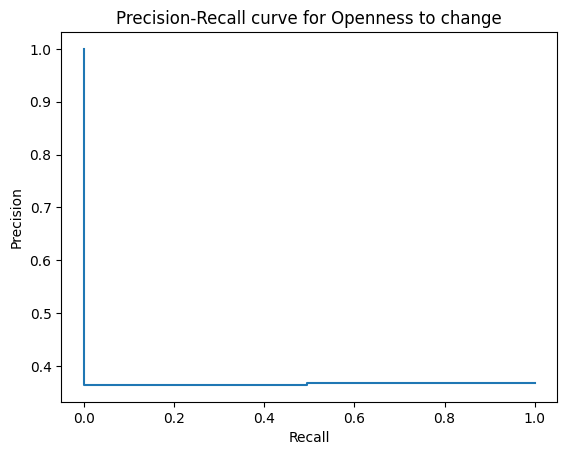

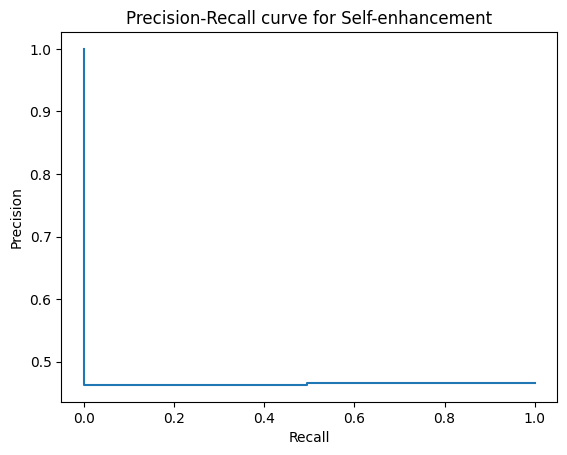

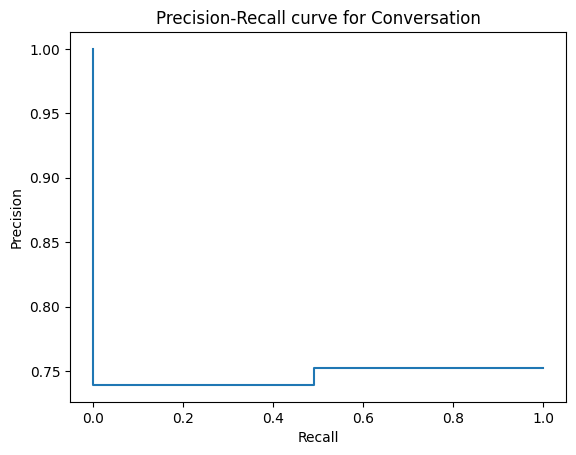

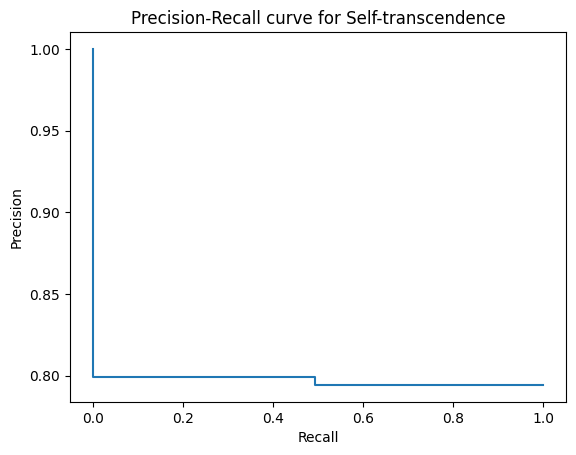

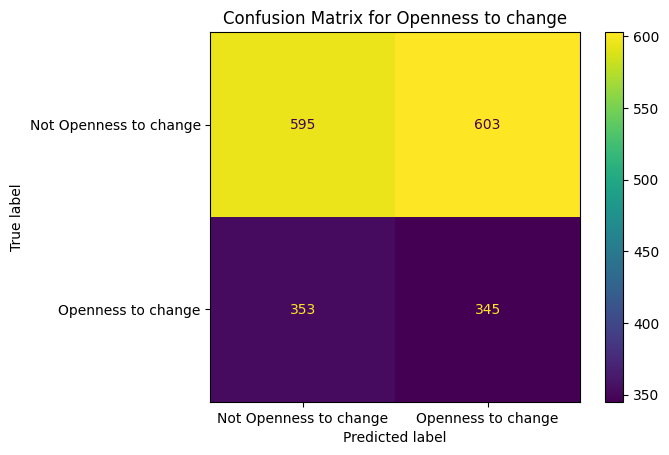

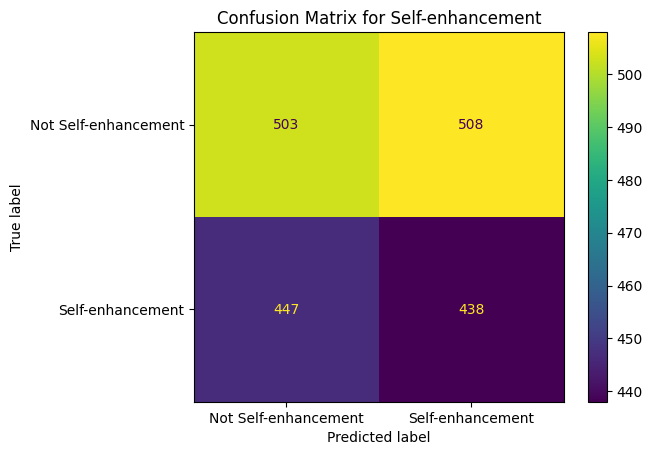

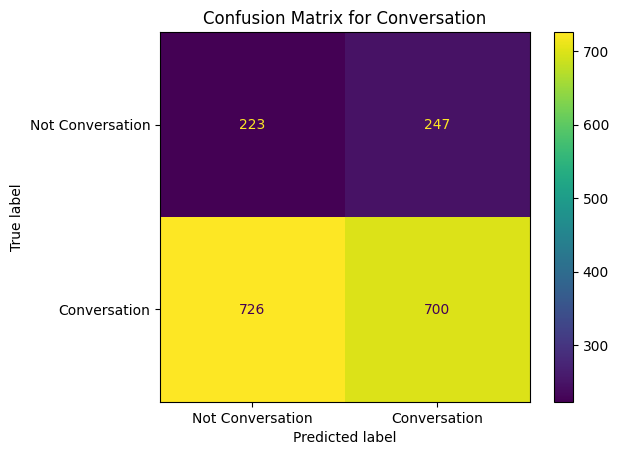

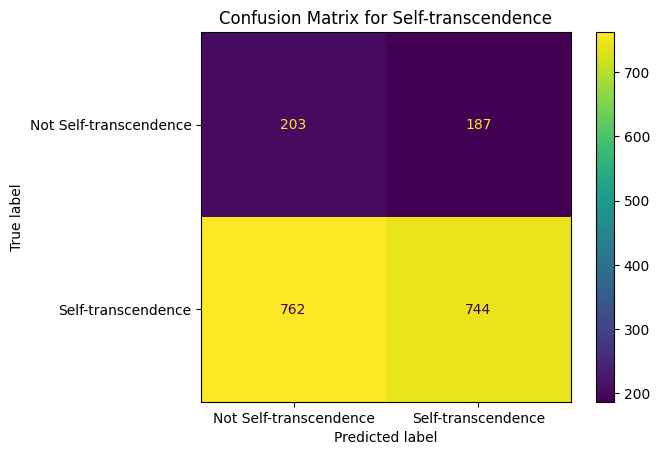

Some Misclassified Samples:
   Openness to change  Self-enhancement  Conversation  Self-transcendence
0                   0                 0             1                   0
1                   0                 0             0                   1
2                   0                 0             1                   1
3                   1                 0             0                   0
4                   0                 0             1                   1


In [ ]:
# Extract the true labels from the validation set
y_true = val_df[labels].values

# Analyze the Random Uniform Classifier
analyze_model_performance(y_true, random_predictions, labels, "random_classifier", sample_data=val_df)

Overall Accuracy: 0.26

Macro F1-Score: 0.44

Metrics for each label:
                   precision recall  f1-score
Openness to change       0.0    0.0       0.0
Self-enhancement         0.0    0.0       0.0
Conversation         0.75211    1.0  0.858519
Self-transcendence  0.794304    1.0  0.885362

Most Frequent Class: Self-transcendence, Frequency: 1506
Least Frequent Class: Openness to change, Frequency: 698


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


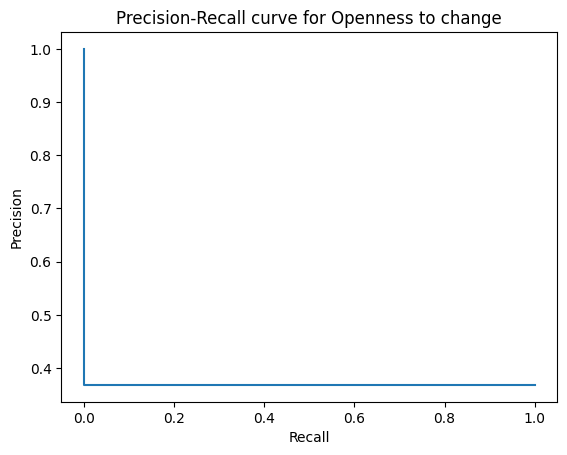

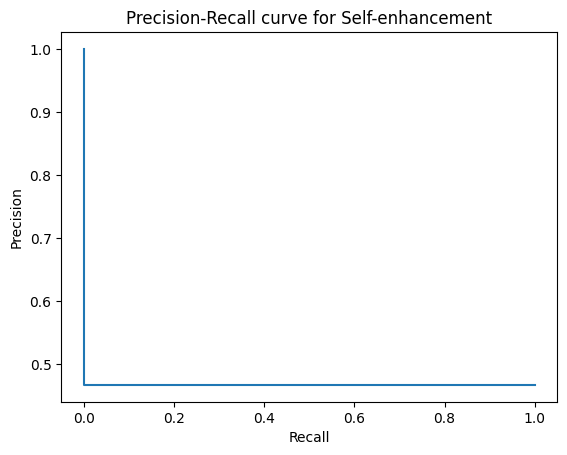

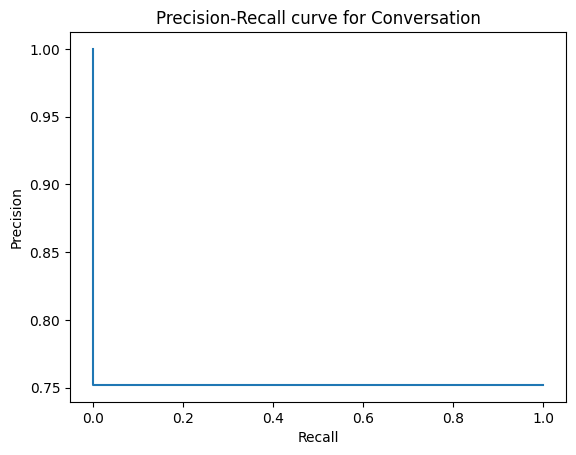

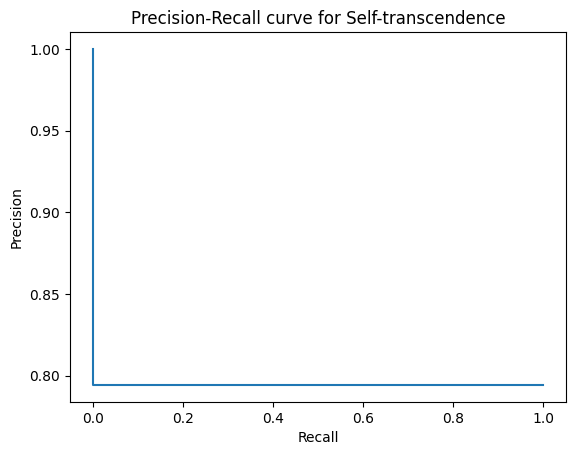

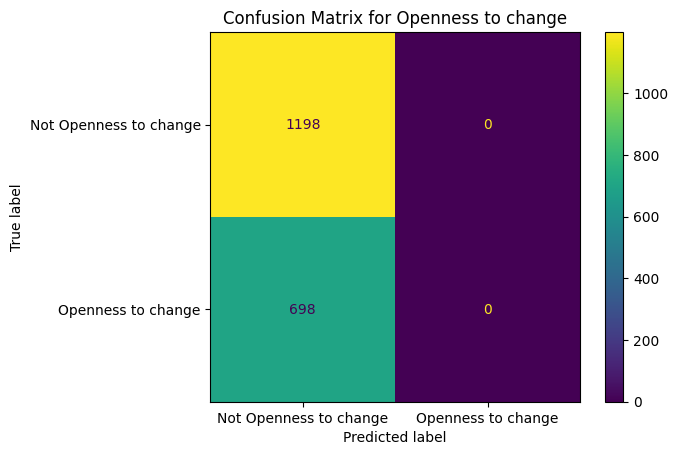

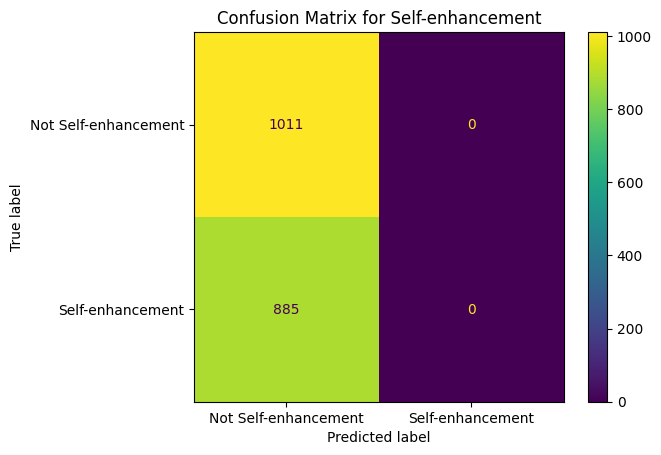

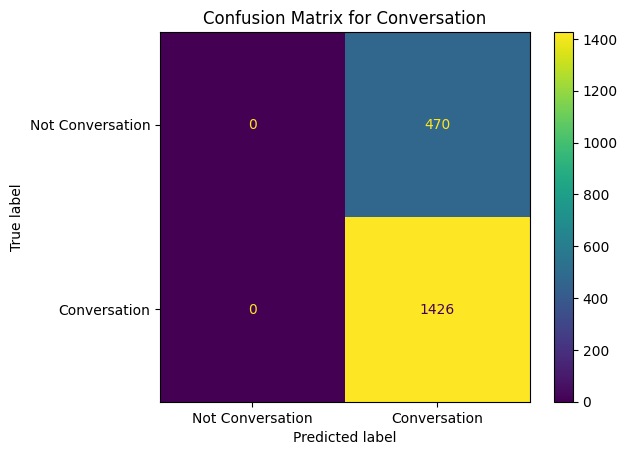

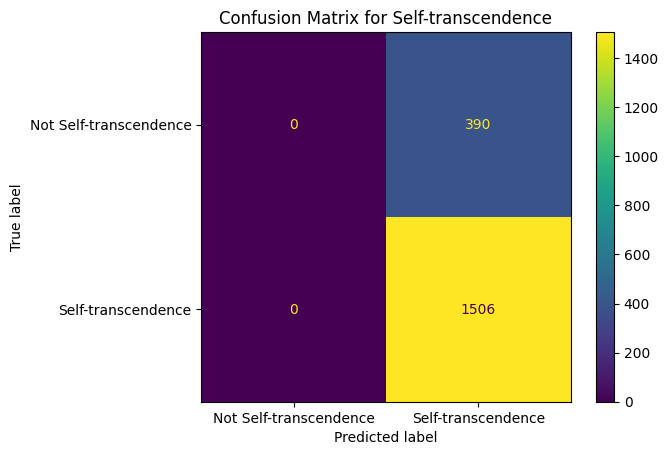

Some Misclassified Samples:
   Openness to change  Self-enhancement  Conversation  Self-transcendence
0                   0                 0             1                   0
1                   0                 0             0                   1
3                   1                 0             0                   0
5                   0                 0             0                   1
7                   0                 0             1                   0


In [ ]:
# Analyze the Majority Classifier
analyze_model_performance(y_true, majority_predictions, labels, "majority_classifier", sample_data=val_df)

Overall Accuracy: 0.15

Macro F1-Score: 0.57

Metrics for each label:
                   precision    recall  f1-score
Openness to change   0.46952  0.518625  0.492852
Self-enhancement    0.717557  0.212429  0.327812
Conversation        0.775159  0.853436  0.812417
Self-transcendence    0.8125  0.552457  0.657708

Most Frequent Class: Self-transcendence, Frequency: 1506.0
Least Frequent Class: Openness to change, Frequency: 698.0


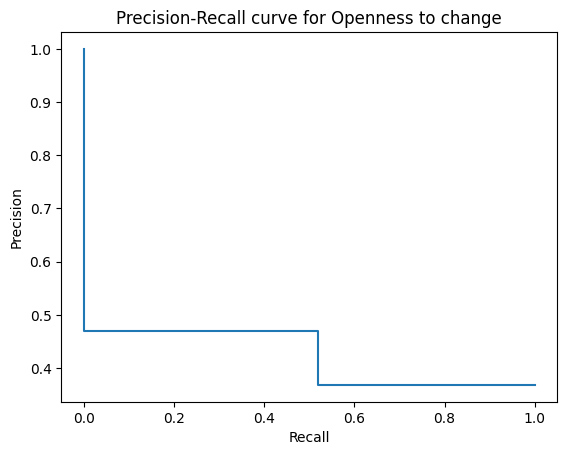

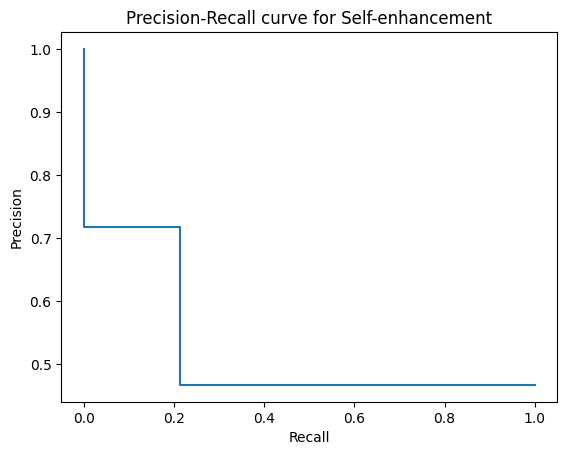

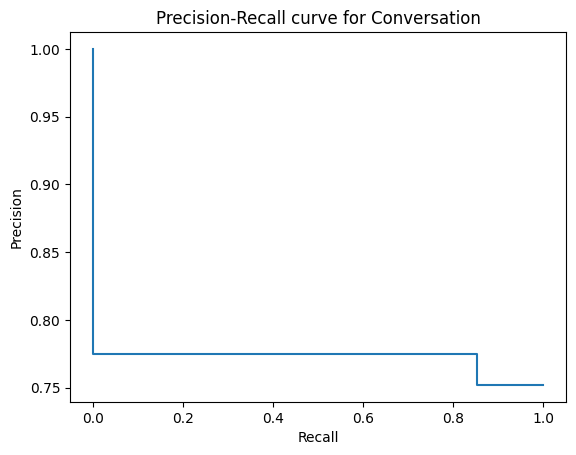

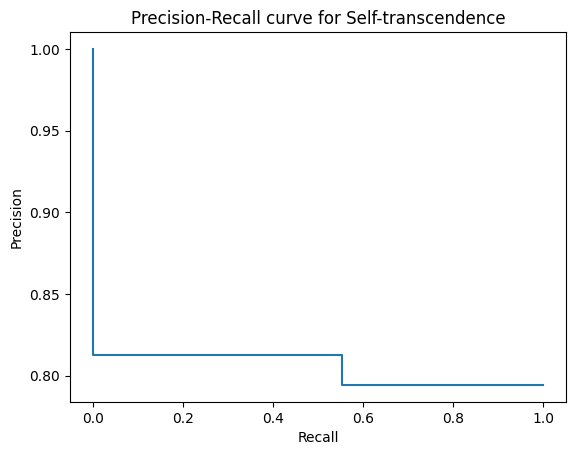

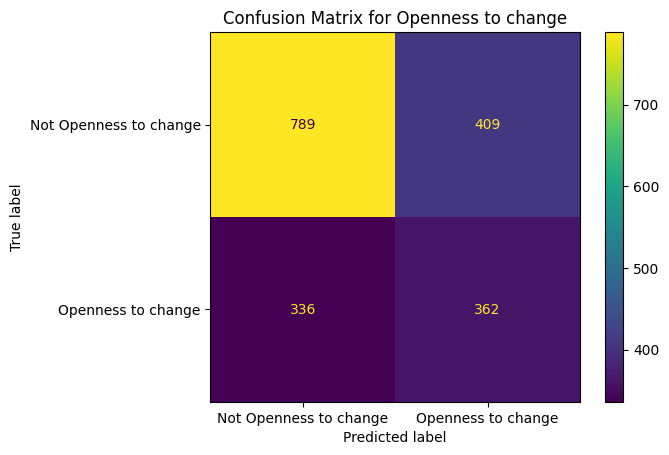

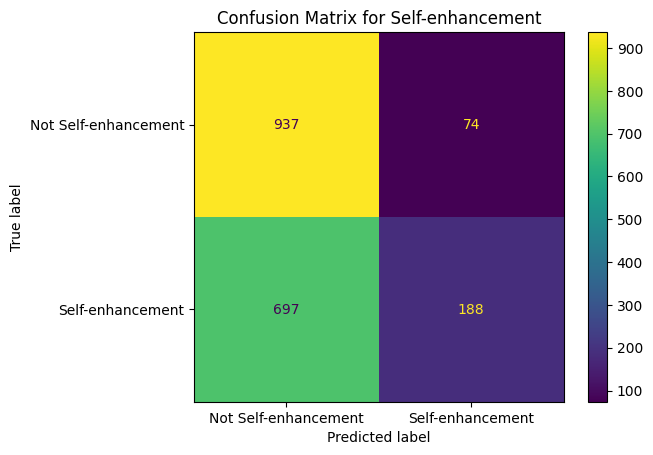

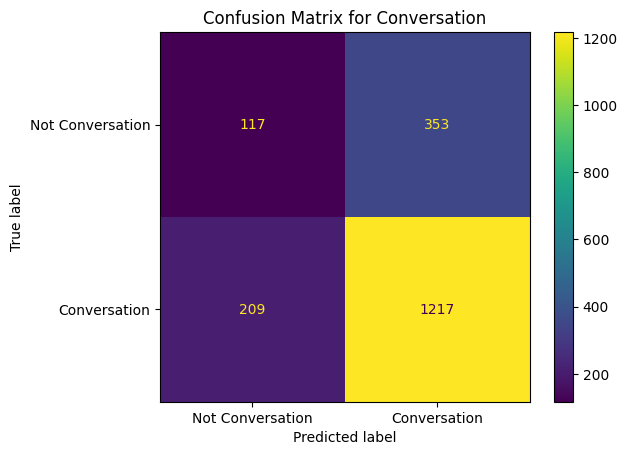

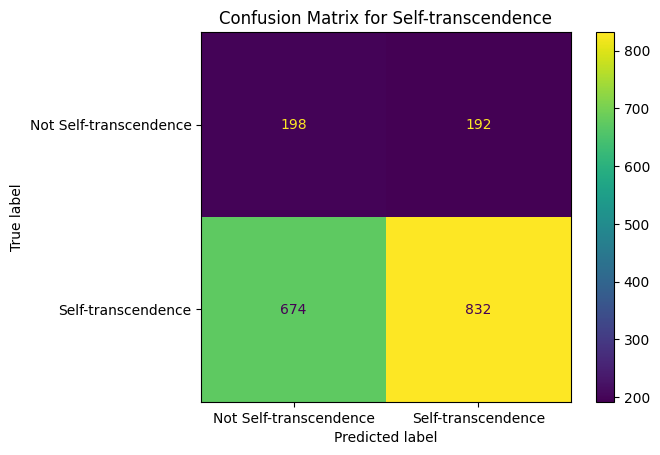

Some Misclassified Samples:
   Openness to change  Self-enhancement  Conversation  Self-transcendence
0                   0                 0             1                   0
1                   0                 0             0                   1
2                   0                 0             1                   1
4                   0                 0             1                   1
5                   0                 0             0                   1


In [ ]:
#Analyze BERT - w/C
analyze_model_performance(y_true_c, y_pred_c, labels, "bert_c", sample_data=val_df)

Overall Accuracy: 0.26

Macro F1-Score: 0.74

Metrics for each label:
                   precision    recall  f1-score
Openness to change  0.580163  0.611748  0.595537
Self-enhancement    0.653804  0.670056   0.66183
Conversation        0.804162  0.921459  0.858824
Self-transcendence  0.820401  0.870518  0.844716

Most Frequent Class: Self-transcendence, Frequency: 1506.0
Least Frequent Class: Openness to change, Frequency: 698.0


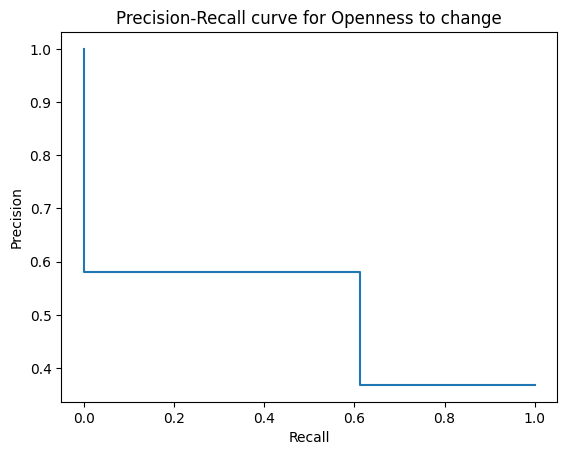

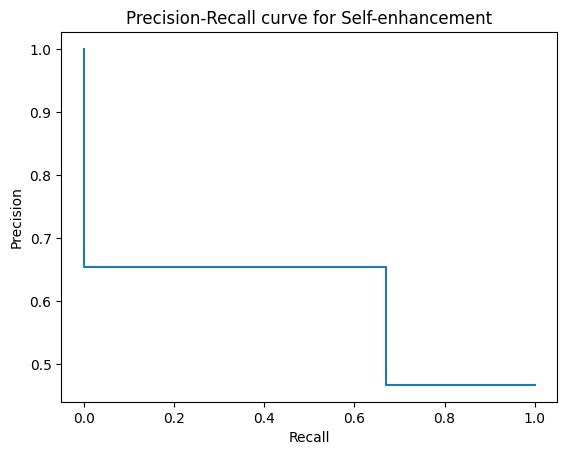

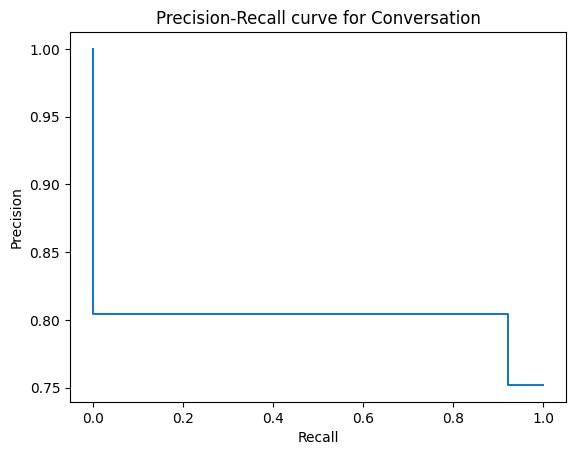

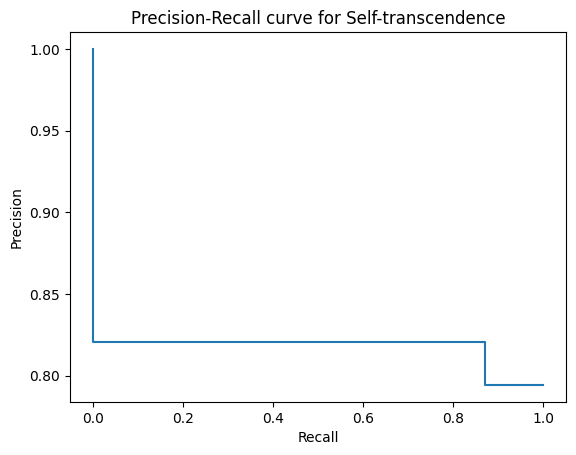

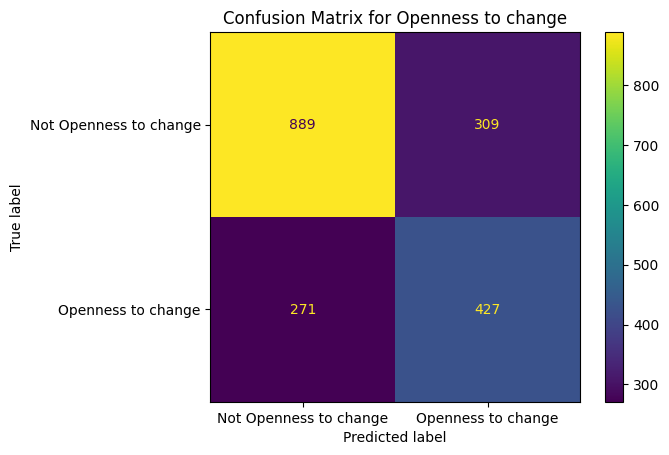

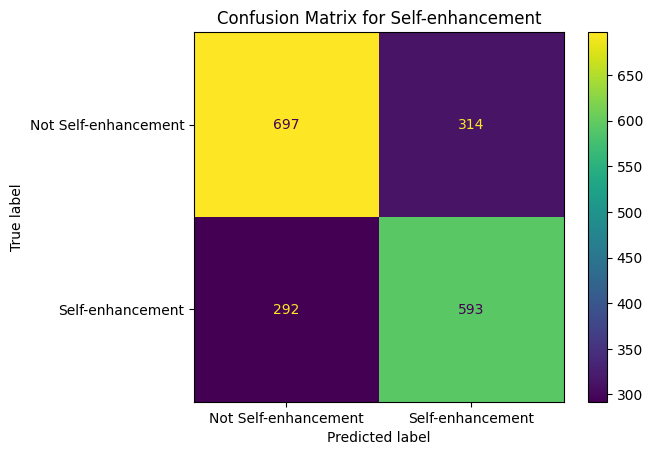

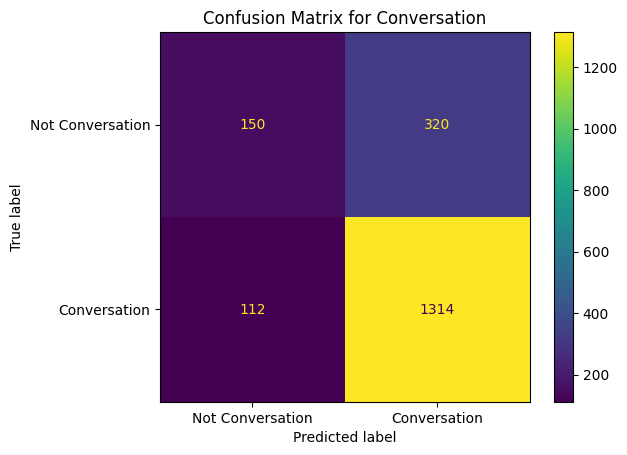

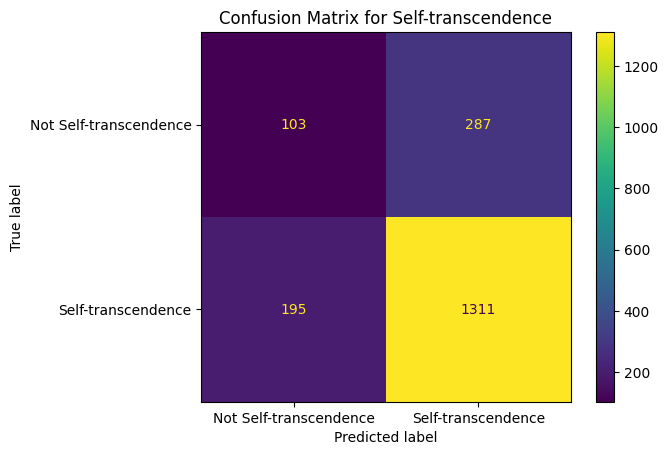

Some Misclassified Samples:
   Openness to change  Self-enhancement  Conversation  Self-transcendence
0                   0                 0             1                   0
1                   0                 0             0                   1
2                   0                 0             1                   1
5                   0                 0             0                   1
6                   0                 0             1                   1


In [ ]:
#Analyze BERT - w/CP
analyze_model_performance(y_true_cp, y_pred_cp, labels, "bert_cp", sample_data=val_df)

Overall Accuracy: 0.27

Macro F1-Score: 0.74

Metrics for each label:
                   precision    recall  f1-score
Openness to change   0.59596  0.591691  0.593817
Self-enhancement    0.664088  0.679096  0.671508
Conversation        0.803198  0.915849  0.855832
Self-transcendence  0.820737   0.87251  0.845832

Most Frequent Class: Self-transcendence, Frequency: 1506.0
Least Frequent Class: Openness to change, Frequency: 698.0


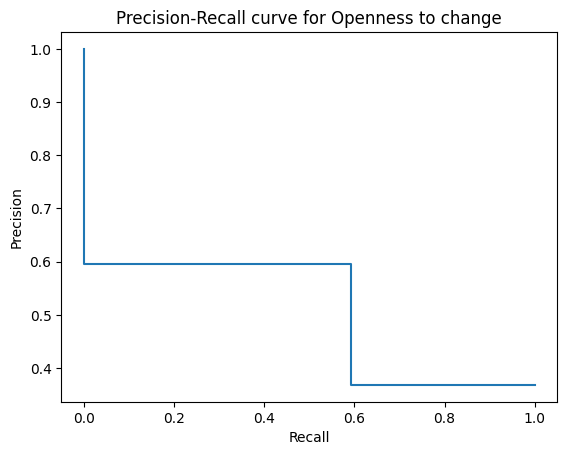

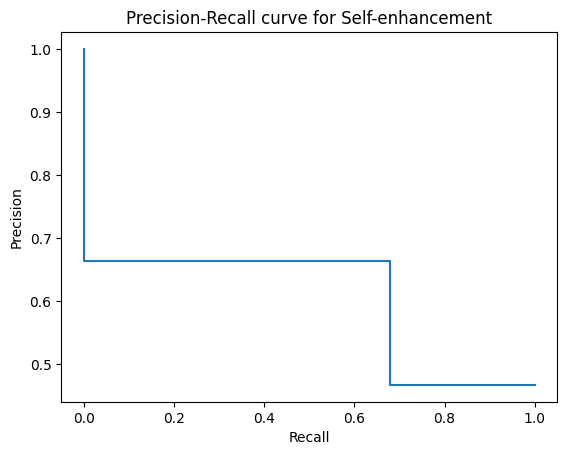

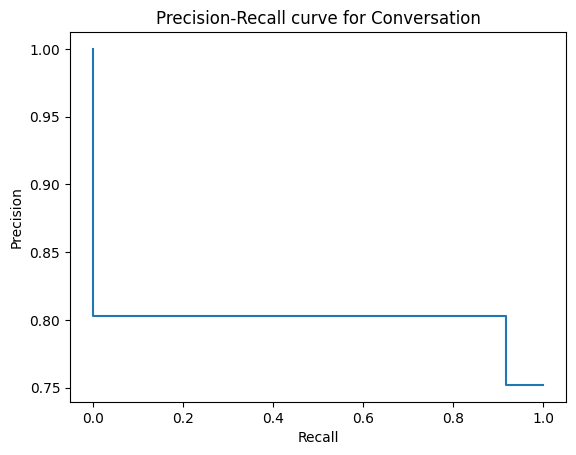

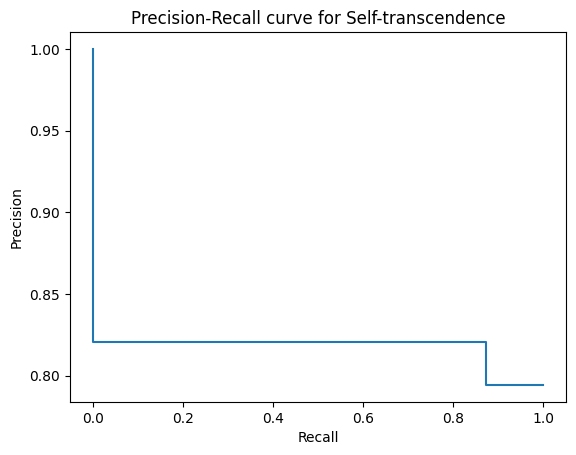

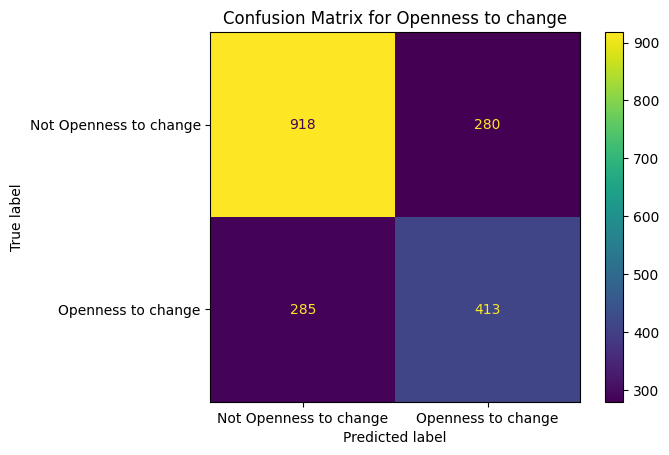

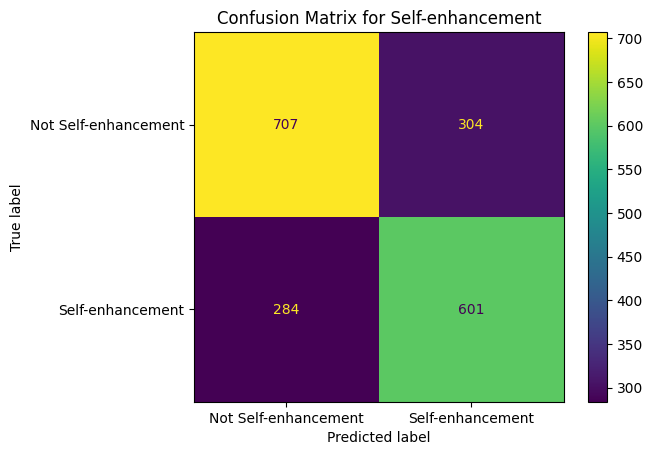

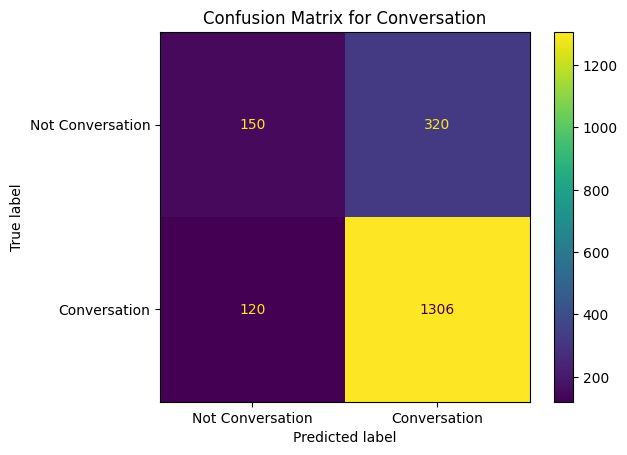

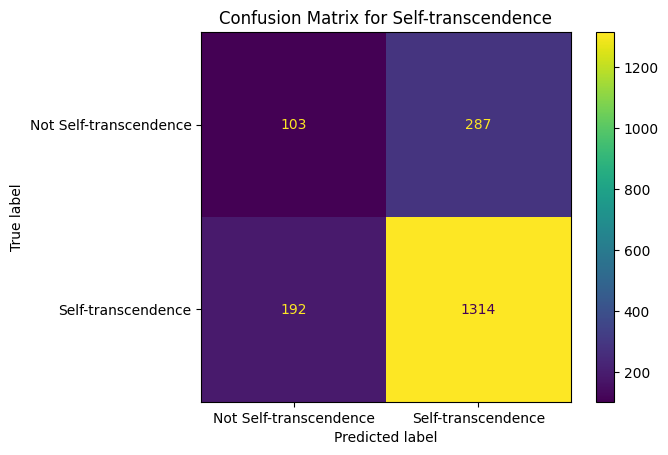

Some Misclassified Samples:
   Openness to change  Self-enhancement  Conversation  Self-transcendence
0                   0                 0             1                   0
1                   0                 0             0                   1
2                   0                 0             1                   1
5                   0                 0             0                   1
6                   0                 0             1                   1


In [ ]:
#Analyze BERT - w/CPS
analyze_model_performance(y_true_cps, y_pred_cps, labels, "bert_cps", sample_data=val_df)

Overall Accuracy: 0.32

Macro F1-Score: 0.76

Metrics for each label:
                   precision    recall  f1-score
Openness to change  0.567335   0.66443  0.612056
Self-enhancement    0.682486  0.689498  0.685974
Conversation         0.95021  0.788249  0.861685
Self-transcendence  0.921647  0.819362    0.8675

Most Frequent Class: Conversation, Frequency: 1719
Least Frequent Class: Openness to change, Frequency: 596


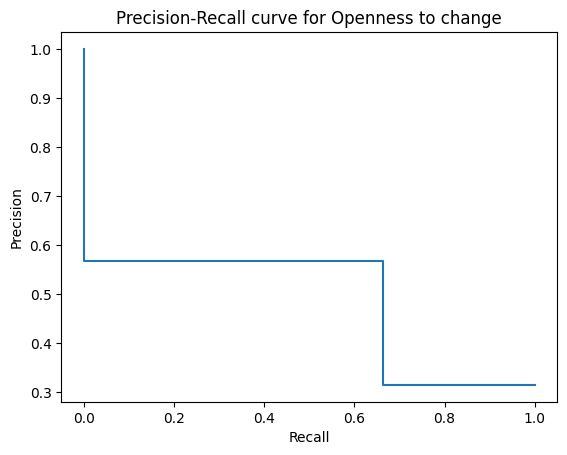

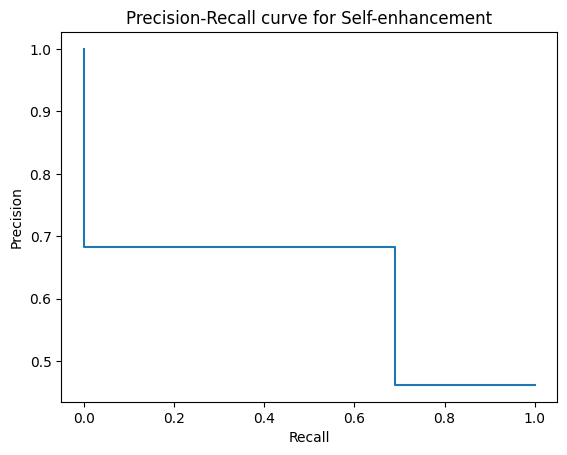

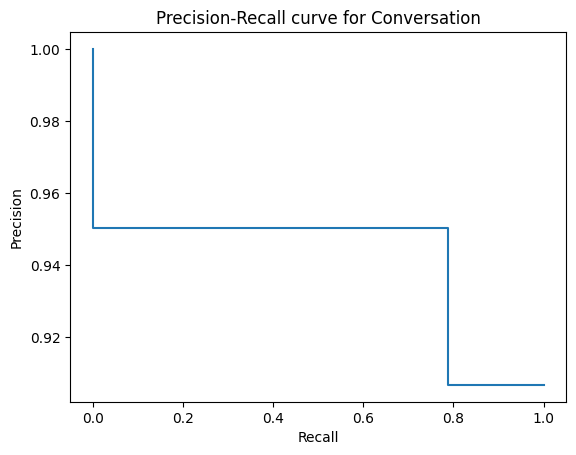

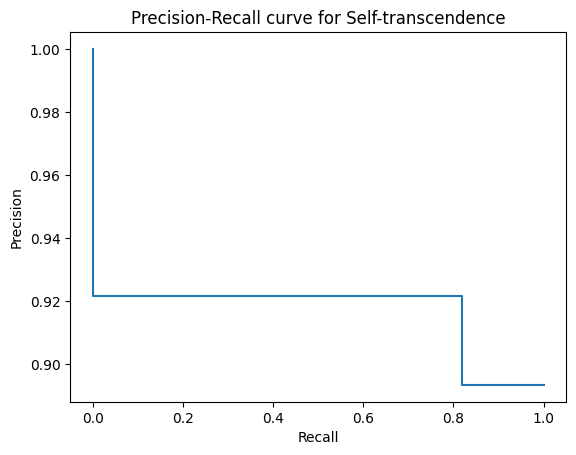

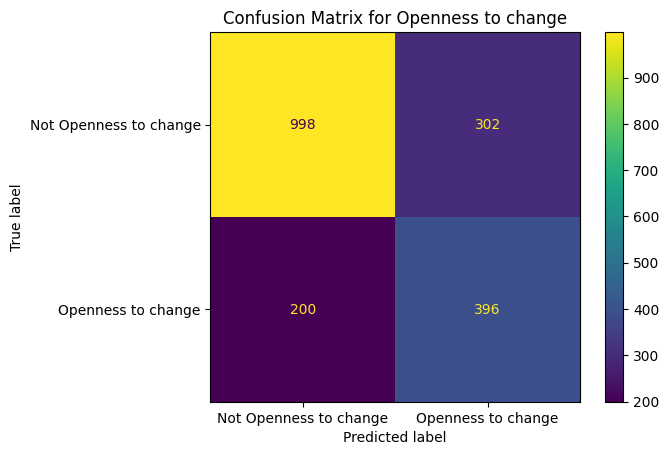

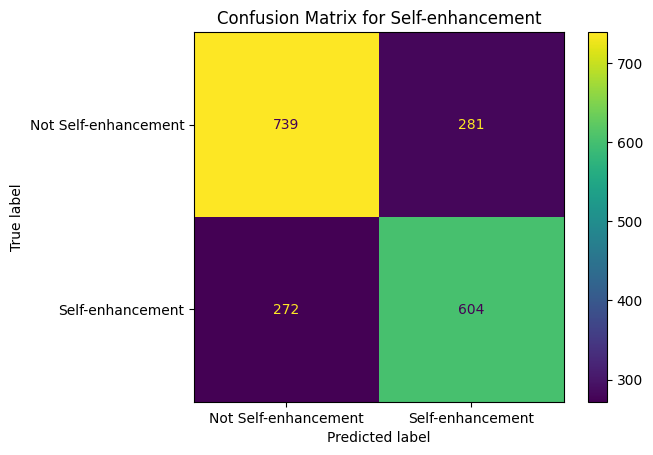

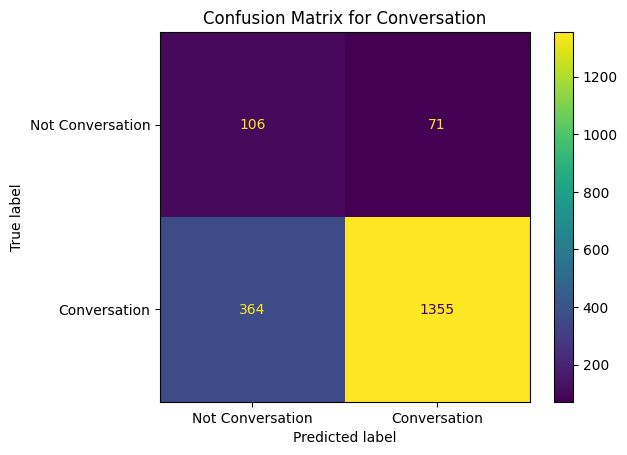

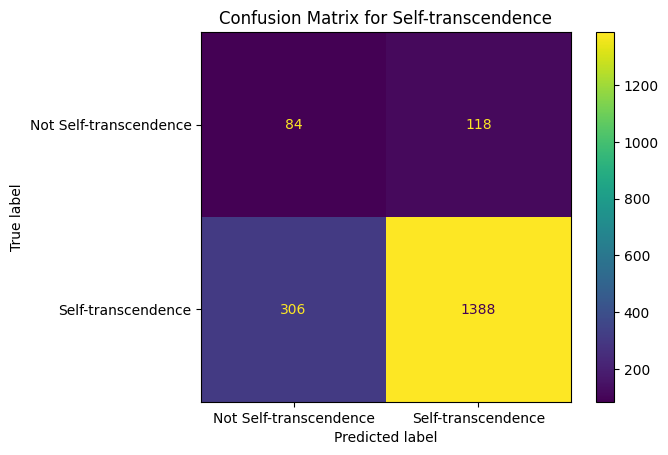

Some Misclassified Samples:
   Openness to change  Self-enhancement  Conversation  Self-transcendence
0                   0                 0             1                   0
2                   0                 0             1                   1
3                   1                 0             0                   0
4                   0                 0             1                   1
5                   0                 0             0                   1


In [ ]:
#Analyze BERT - w/CPS 2
analyze_model_performance(y_true_cps2, y_pred_cps2, labels, "bert_cps2", sample_data=val_df)

In [ ]:
dict_metrics

{'random_classifier':                    precision    recall  f1-score
 Openness to change  0.363924  0.494269  0.419198
 Self-enhancement    0.463002  0.494915  0.478427
 Conversation        0.739176  0.490884  0.589971
 Self-transcendence  0.799141  0.494024  0.610587,
 'majority_classifier':                    precision recall  f1-score
 Openness to change       0.0    0.0       0.0
 Self-enhancement         0.0    0.0       0.0
 Conversation         0.75211    1.0  0.858519
 Self-transcendence  0.794304    1.0  0.885362,
 'bert_c':                    precision    recall  f1-score
 Openness to change   0.46952  0.518625  0.492852
 Self-enhancement    0.717557  0.212429  0.327812
 Conversation        0.775159  0.853436  0.812417
 Self-transcendence    0.8125  0.552457  0.657708,
 'bert_cp':                    precision    recall  f1-score
 Openness to change  0.580163  0.611748  0.595537
 Self-enhancement    0.653804  0.670056   0.66183
 Conversation        0.804162  0.921459  0.8588

In [ ]:
dict_macro_f1

{'random_classifier': 0.5245456083559075,
 'majority_classifier': 0.43597012912686206,
 'bert_c': 0.5726970071004811,
 'bert_cp': 0.7402268352384197,
 'bert_cps': 0.7417475027182082,
 'bert_cps2': 0.756803683631619}

In [ ]:
def plot_model_metrics(models_dict, metric, title):
    for model_name, df in models_dict.items():
        if metric not in df.columns:
            raise ValueError(f"Il DataFrame per '{model_name}' non contiene la colonna '{metric}'.")

    n_categories = [df.shape[0] for df in models_dict.values()]
    if len(set(n_categories)) > 1:
        raise ValueError("I DataFrame non hanno lo stesso numero di categorie.")

    categories = list(models_dict[next(iter(models_dict))].index)
    bar_positions = np.arange(len(categories))
    bar_width = 0.1

    # Impostazione dei colori e degli stili dei marker
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
    markers = ['o', 's', '^', 'D', 'p', '*']

    plt.figure(figsize=(12, 8))
    plt.title(title)
    # linee tratteggiate orizzontali come griglia
    plt.grid(True, which='both', axis='y', linestyle='--', color='lightgray', alpha=0.7)


    # Per ogni modello, plot le barre e le linee con marker
    for i, (model_name, df) in enumerate(models_dict.items()):
        model_pos = bar_positions + (i - len(models_dict) / 2) * bar_width + bar_width / 2
        plt.bar(model_pos, df[metric], width=bar_width, color='lightgray', edgecolor='black', alpha=0.5, linewidth=0)
        plt.plot(model_pos, df[metric], color=colors[i % len(colors)], marker=markers[i % len(markers)],
                 linestyle='-', markeredgewidth=1.5, label=model_name)

    plt.xticks(bar_positions, categories, rotation=45)
    plt.ylabel(metric.replace('-', ' ').title())
    plt.legend()
    plt.tight_layout()
    plt.savefig('plot_models_metrics.png', dpi=300)
    plt.show()


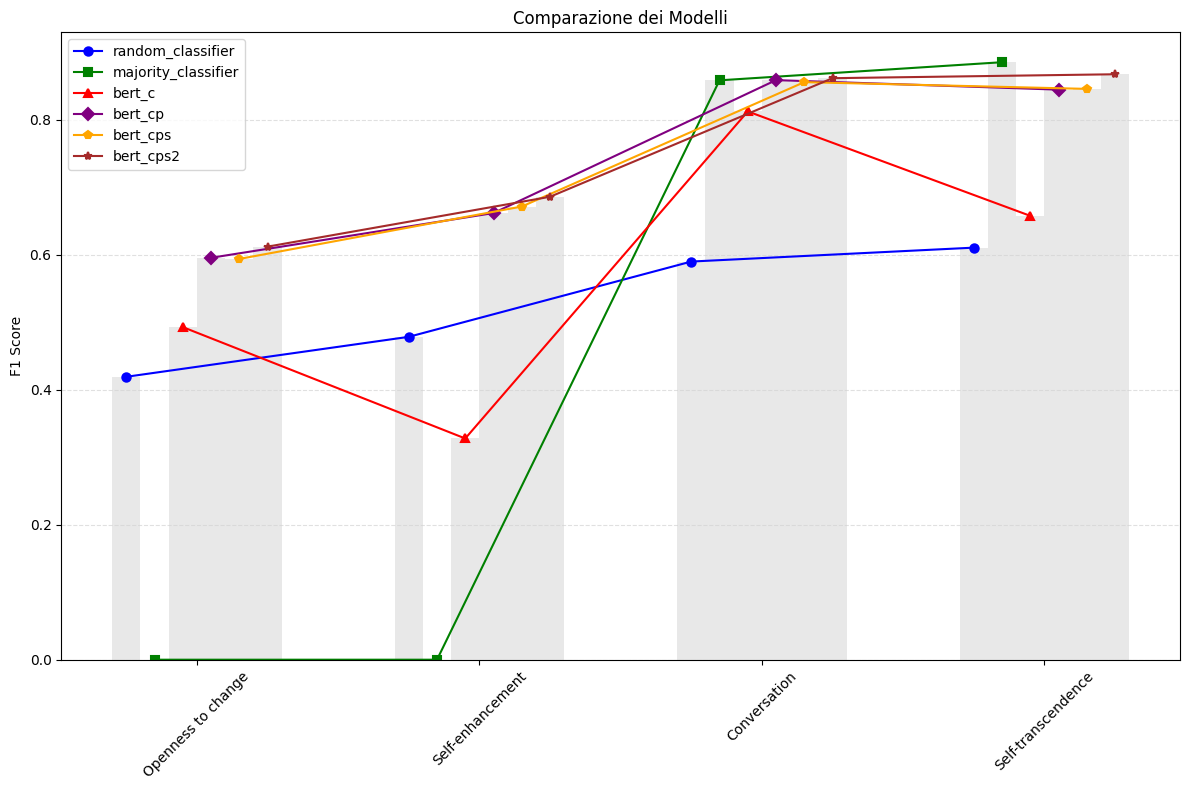

In [ ]:
plot_model_metrics(dict_metrics, 'f1-score', "Comparazione dei Modelli")


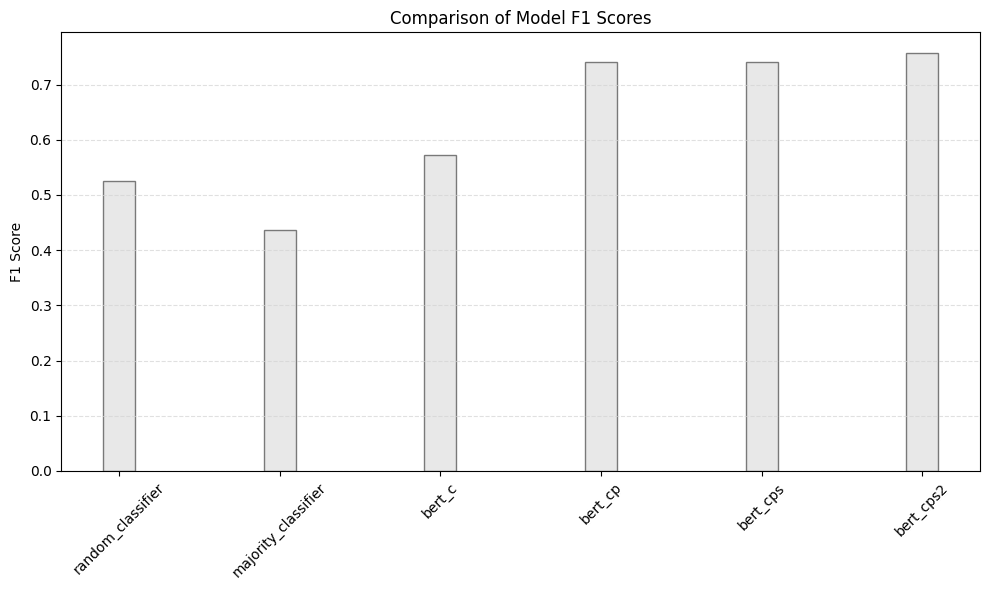

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_model_metrics(models_dict, metric, title):
    # Preparazione dei dati per il plot
    model_names = list(models_dict.keys())
    metric_values = list(models_dict.values())

    bar_positions = np.arange(len(model_names))
    bar_width = 0.2  # Riduzione della larghezza delle barre

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.grid(True, which='both', axis='y', linestyle='--', color='lightgray', alpha=0.7)

    # Plot delle barre con colore grigio trasparente
    plt.bar(bar_positions, metric_values, width=bar_width, color='lightgray', alpha=0.5, edgecolor='black')

    plt.xticks(bar_positions, model_names, rotation=45)
    plt.ylabel(metric.replace('_', ' ').title())

    plt.tight_layout()
    plt.savefig('plot_models_metrics.png', dpi=300)
    plt.show()


plot_model_metrics(dict_macro_f1, 'F1 Score', 'Comparison of Model F1 Scores')